In [1]:
library(dplyr)
library(tidyr)
library(tidyverse)
library(sf)
library(MatchIt)
library(fixest)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.4
✔ ggplot2   3.4.1     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.1.8
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Linking to GEOS 3.8.0, GDAL 3.0.4, PROJ 6.3.1; sf_use_s2() is TRUE



## 1. Add Tree Loss

In [2]:
# Load matching frame
mf = st_read(file.path("/kaggle/input/mf-rbase-1km-cameroon/mf_rBase_1km_Cameroon.gpkg")) %>%
  filter(group==0 | group==1) %>%
  st_drop_geometry()

Reading layer `mf_rBase_1km' from data source 
  `/kaggle/input/mf-rbase-1km-cameroon/mf_rBase_1km_Cameroon.gpkg' 
  using driver `GPKG'
Simple feature collection with 466846 features and 29 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -222599.3 ymin: 183657.1 xmax: 632400.7 ymax: 1445657
Projected CRS: WGS 84 / UTM zone 33N


In [3]:
# The calculation of tree loss area is performed at dataframe base
# Get the column names of tree cover time series
colnames_tree = names(mf)[startsWith(names(mf), "fc")]
# Drop the first year
dropFirst = tail(colnames_tree, -1)
# Drop the last year
dropLast = head(colnames_tree, -1)
# Set list of new column names for tree loss time series
colnames_loss = dropFirst %>% str_split(., "_")
# Add new columns: treeloss_tn = treecover_tn - treecover_t(n-1)  
for (i in 1:length(dropFirst)) {
  new_colname <- paste0("treeloss_pct_", colnames_loss[[i]][3])
    # Calc absolute value of Year_t - Year_(t-1) 
  mf[[new_colname]] <- abs(mf[[dropFirst[i]]] - mf[[dropLast[i]]])
}

In [4]:
# Add column: average treeloss before funding starts, i.e. avg. of treeloss from 2001 to 2006
mf$avgLoss_pre_fund = round(rowMeans(mf[grepl("treeloss", names(mf))][1:6]), 2)

## 2a. Matching

* Good Balance when,
`Std. Mean Diff` and `eCDF stats` close to **`0`** and `variance ratios` close to **`1`**.

* `Std.Pair Diff` displays the average absolute within-pair difference of each covariate. when they're small, better balance, and estimated effects are more robust to misspecification of the outcome model.

In [5]:
# Make cut-off list ####
lst_cutoffs = c()

# Quantile in 8 parts
lst_cutoffs$accessiblity_min = as.integer(quantile(mf$accessiblity_min, probs = seq(0, 1, 0.05), na.rm=TRUE))

lst_cutoffs$clay_._mean_0_20 = as.integer(quantile(mf$clay_._mean_0_20, probs = seq(0, 1, 0.05), na.rm=TRUE))
#lst_cutoffs$clay_._mean_0_20 = as.integer(c(0,10,20,30, 32,34,36,38,40, 50,60,70,80,90,100))

lst_cutoffs$elevation_m = as.integer(quantile(mf$elevation_m, probs = seq(0, 1, 0.025), na.rm=TRUE))

lst_cutoffs$TRI = as.integer(quantile(mf$TRI, probs = seq(0, 1, 0.1), na.rm=TRUE))

lst_cutoffs$fc_._2000 = as.integer(quantile(mf$fc_._2000, probs = seq(0, 1, 0.025), na.rm=TRUE))

lst_cutoffs$avgLoss_pre_fund = as.integer(quantile(mf$avgLoss_pre_fund, probs = seq(0, 1, 0.005), na.rm=TRUE))

In [6]:
# CEM Match
out.cem = matchit(group ~ accessiblity_min + clay_._mean_0_20 +
                   
                   elevation_m + TRI + 
                   
                   fc_._2000 + avgLoss_pre_fund,
                 
                 data = mf, method = "cem", cutpoints = lst_cutoffs)

In [7]:
# Summary of matching output
summary(out.cem)


Call:
matchit(formula = group ~ accessiblity_min + clay_._mean_0_20 + 
    elevation_m + TRI + fc_._2000 + avgLoss_pre_fund, data = mf, 
    method = "cem", cutpoints = lst_cutoffs)

Summary of Balance for All Data:
                 Means Treated Means Control Std. Mean Diff. Var. Ratio
accessiblity_min      360.6112      199.1637          0.7626     1.1069
clay_._mean_0_20       31.2334       33.9468         -1.1669     0.0940
elevation_m           576.9504      687.1815         -0.1633     4.5917
TRI                    44.2489       22.3999          0.7407     2.5249
fc_._2000              99.1745       90.5476          1.3956     0.0525
avgLoss_pre_fund        0.0085        0.0576         -0.9172     0.0404
                 eCDF Mean eCDF Max
accessiblity_min    0.1001   0.4054
clay_._mean_0_20    0.0912   0.4023
elevation_m         0.1276   0.4926
TRI                 0.1261   0.4250
fc_._2000           0.0862   0.1198
avgLoss_pre_fund    0.0074   0.1092

Summary of Balance for Mat

## 2b. Plot Histogramm

**Black line --> Treatment, Grey line --> Control**

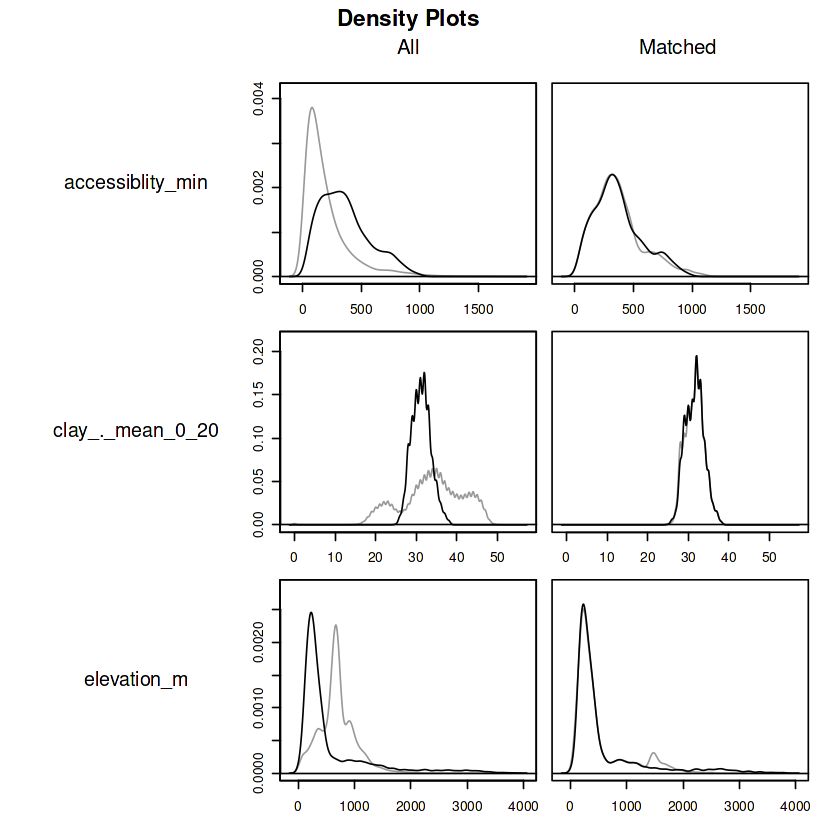

In [8]:
# Plot ####
plot(out.cem, type = "density", interactive = FALSE,
     which.xs = c("accessiblity_min", "clay_._mean_0_20", "elevation_m"))

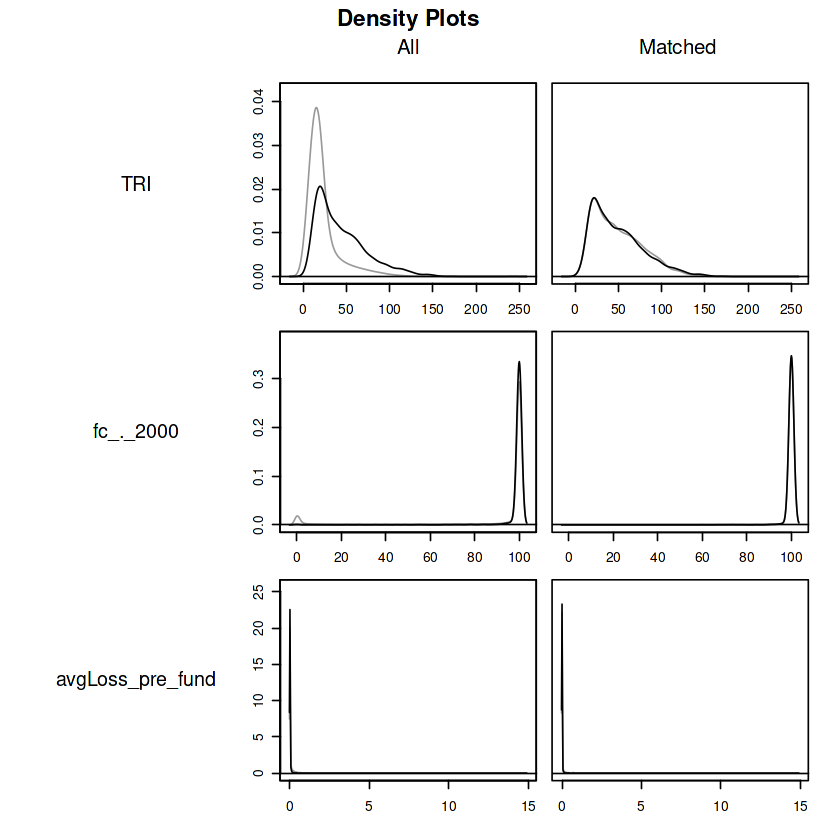

In [9]:
plot(out.cem, type = "density", interactive = FALSE,
     which.xs = c("TRI", "fc_._2000", "avgLoss_pre_fund"))

## 3. Panelize Matched Dataframe

In [10]:
# Pivot DF of matched objects
matched.wide = match.data(object=out.cem, data=mf)
print(paste0("The total number of matched items: ", as.character(nrow(matched.wide))))

head(matched.wide)

[1] "The total number of matched items: 9295"


,gridID,group,wdpaid,fc_._2000,fc_._2001,fc_._2002,fc_._2003,fc_._2004,fc_._2005,fc_._2006,⋯,treeloss_pct_2015,treeloss_pct_2016,treeloss_pct_2017,treeloss_pct_2018,treeloss_pct_2019,treeloss_pct_2020,treeloss_pct_2021,avgLoss_pre_fund,weights,subclass
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
3,497,0,0,100,100,100,100,100,100,100,⋯,0,0,0,0,0,0,0,0,0.1093155,1
4,498,0,0,100,100,100,100,100,100,100,⋯,0,0,0,0,0,0,0,0,0.1093155,1
5,532,0,0,100,100,100,100,100,100,100,⋯,0,0,0,0,0,0,0,0,0.1093155,1
6,533,0,0,100,100,100,100,100,100,100,⋯,0,0,0,0,0,0,0,0,0.5465777,2
31,687,0,0,100,100,100,100,100,100,100,⋯,0,0,0,0,0,0,0,0,0.1261333,3
42,734,0,0,100,100,100,100,100,100,100,⋯,0,0,0,0,0,0,0,0,0.8198665,4


In [11]:
# Average treecover 2000 of matched treatment group, identical with CEM summary
matched.wide %>%
    filter(group==1) %>% select(c(fc_._2000)) %>%
    summarise(across(everything(), mean))

fc_._2000
<dbl>
99.82716


In [12]:
# Average treecover 2000 of matched control group, NOT identical with CEM summary!
matched.wide %>%
    filter(group==0) %>% select(c(fc_._2000)) %>%
    summarise(across(everything(), mean))

fc_._2000
<dbl>
99.84195


In [13]:
# Pivot Wide ==> Pivot Long
matched.long = matched.wide %>%
    select(c(group, wdpaid, gridID, weights, starts_with("fc"))) %>%
    pivot_longer(cols = c(starts_with("fc")),
                 names_to = c("var", "year"),
                 names_sep = "_._",
                 values_to = "fc_pct")

head(matched.long)

group,wdpaid,gridID,weights,var,year,fc_pct
<dbl>,<dbl>,<int>,<dbl>,<chr>,<chr>,<dbl>
0,0,497,0.1093155,fc,2000,100
0,0,497,0.1093155,fc,2001,100
0,0,497,0.1093155,fc,2002,100
0,0,497,0.1093155,fc,2003,100
0,0,497,0.1093155,fc,2004,100
0,0,497,0.1093155,fc,2005,100


## 4. Plotting

In [14]:
# DF for plotting Trend
df_plotTrend = matched.long %>%
    group_by(group, year) %>%
    summarise(fc_avg = mean(fc_pct, na.rm=TRUE), n = n())
df_plotTrend

`summarise()` has grouped output by 'group'. You can override using the
`.groups` argument.


group,year,fc_avg,n
<dbl>,<chr>,<dbl>,<int>
0,2000,99.84195,7123
0,2001,99.81964,7123
0,2002,99.80227,7123
0,2003,99.79420,7123
0,2004,99.77083,7123
0,2005,99.75352,7123
0,2006,99.72345,7123
0,2007,99.65995,7123
0,2008,99.60719,7123


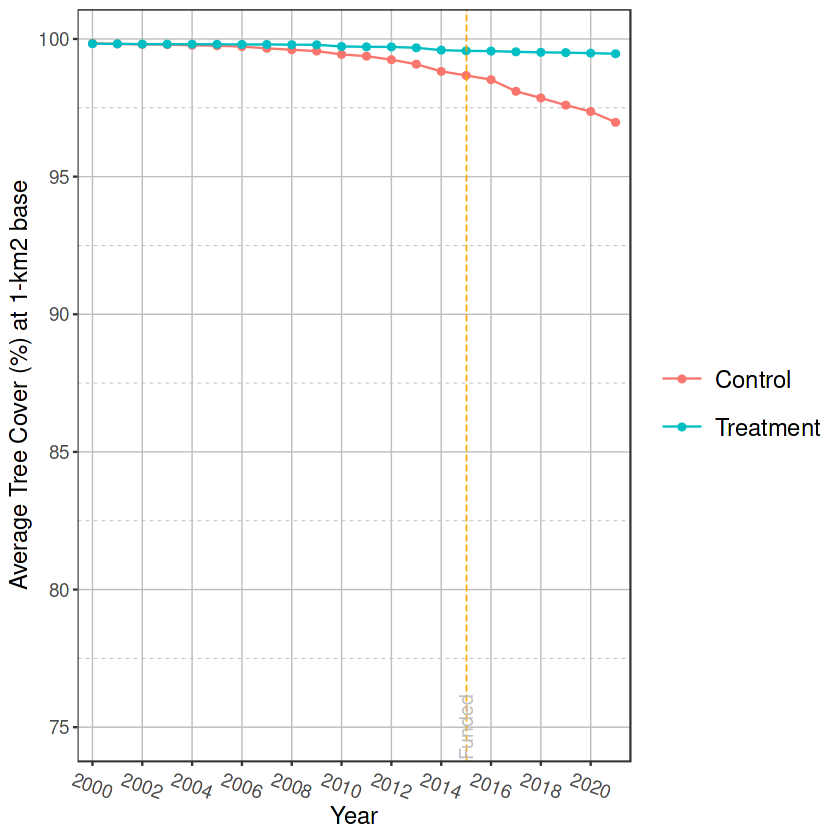

In [15]:
# Trend Plot
ggplot(df_plotTrend, 
       aes(x = year, y = fc_avg)) +
    geom_line(aes(group = group, color = as.character(group))) +
    geom_point(aes(color = as.character(group))) +
    geom_vline(aes(xintercept = "2015"), linetype = "longdash", color="orange", linewidth = 0.35) +
    #geom_text(aes(x="2015", label="Funding Start", y=75), colour="orange", angle=90, text=element_text(size=10)) +
    annotate("text", x="2015", y=75, label="Funded", angle=90, size=4, color="grey") +

    #scale_y_continuous(breaks=seq(80,100,5), labels=paste(seq(80,100,5)),
    #                   expand=c(0,80), limits=c(80,100)) +
    scale_x_discrete(breaks=seq(2000,2020,2), labels=paste(seq(2000,2020,2))) +
    scale_color_hue(labels = c("Control", "Treatment")) +

    labs(x = "Year", y = "Average Tree Cover (%) at 1-km2 base", color = "Group") +
    #coord_fixed() +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle = -20, hjust = 0.5, vjust = 0.5),
        axis.text=element_text(size=11),
        axis.title=element_text(size=14),
        
        #legend.position = "bottom",
        legend.title = element_blank(),
        legend.text=element_text(size=14),
        #legend.spacing.x = unit(1.0, 'cm'),
        legend.spacing.y = unit(0.75, 'cm'),
        legend.key.size = unit(2, 'line'),

        panel.grid.major.x = element_line(color = 'grey', linewidth = 0.3, linetype = 1),
        panel.grid.minor.x = element_line(color = 'grey', linewidth = 0.2, linetype = 2),
        panel.grid.major.y = element_line(color = 'grey', linewidth = 0.3, linetype = 1),
        panel.grid.minor.y = element_line(color = 'grey', linewidth = 0.2, linetype = 2)

    )

## 5. Regression

In [16]:
head(matched.long)

group,wdpaid,gridID,weights,var,year,fc_pct
<dbl>,<dbl>,<int>,<dbl>,<chr>,<chr>,<dbl>
0,0,497,0.1093155,fc,2000,100
0,0,497,0.1093155,fc,2001,100
0,0,497,0.1093155,fc,2002,100
0,0,497,0.1093155,fc,2003,100
0,0,497,0.1093155,fc,2004,100
0,0,497,0.1093155,fc,2005,100


In [17]:
feols(fc_pct ~ group | year,
      data = matched.long, 
      weights = matched.long$weights)

OLS estimation, Dep. Var.: fc_pct
Observations: 204,490 
Weights: matched.long$weights 
Fixed-effects: year: 22
Standard-errors: Clustered (year) 
      Estimate Std. Error t value   Pr(>|t|)    
group 0.477592    0.11126 4.29258 0.00032277 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 3.20455     Adj. R2: 0.028887
                Within R2: 0.003962